plot kd from argo, ws profiles, and ooi array

In [1]:
%pip install --quiet geopy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from scipy import stats
import glob
from geopy.distance import geodesic

In [17]:
def matchkdvals(file_name,ground):
    is2 = pd.read_csv(file_name)# load data
    t = datetime.strptime(file_name[8:22],'%Y%m%d%H%M%S')# strip time from file name
    t = t.replace(tzinfo=timezone.utc)
    tdiff = abs(t - ground['time']) # calculate difference between file time and each argo entry
    # find all entries in argo where tdiff<6h
    ground_sub = ground[tdiff<(timedelta(hours=12))]
    rows = ground_sub.index.values
    
    # find all entries in argo where distance is < 10km
    for jj in rows:
        ground_coords = (ground_sub.loc[jj,'lat'],ground_sub.loc[jj,'lon']) #lat,lon tuple
        dist = np.ones(len(is2))*np.nan
        for kk in range(len(is2)):
            is2_coords = (is2.loc[kk,'latitude'],is2.loc[kk,'longitude'])
            try:
                dist[kk] = geodesic(ground_coords, is2_coords).km
            except:
                continue
        idx = np.argmin(dist)
        if np.min(dist)<10:
            ground.loc[jj,'icesat2_kd'] = is2.loc[idx,'kd']
            ground.loc[jj,'dist_offset'] = np.min(dist)
            ground.loc[jj,'time_offset'] = tdiff[jj]
            
    return ground


In [18]:
pname = 'results/'

# load argo data:
argo = pd.read_csv('data/Dataset_Kd_Paper_2018.csv')
argo["time"] = pd.to_datetime(argo["dt_float"]-719529,unit='d',utc=True).round('s')
argo = argo.rename(columns={"lat_float": "lat", "lon_float": "lon"})
# argo['dt_float'] = pd.to_datetime(argo["dt_float"],format='ISO8601').round('s')
argo['icesat2_kd'] = np.nan
argo['dist_offset'] = np.nan
argo['time_offset'] = timedelta(hours=0)
fnames = glob.glob(pname+'*Further.csv')
for file in fnames:
    # print(file)
    argo = matchkdvals(file,argo)

# load ooi data:
ooi = pd.read_csv(pname+'ooi_kdcalculations10m.csv',index_col=0)
ooi['time'] = pd.to_datetime(ooi["time"],format='ISO8601').round('s')
ooi['icesat2_kd'] = np.nan
ooi['dist_offset'] = np.nan
ooi['time_offset'] = timedelta(hours=0)
fnames = glob.glob(pname+'*Further.csv')
for file in fnames:
    ooi = matchkdvals(file,ooi)

# load ws data:
ws = pd.read_csv(pname+'ws_kdcalculations10m.csv',index_col=0)
ws['time'] = pd.to_datetime(ws["time"],format='ISO8601').round('s')
ws['icesat2_kd'] = np.nan
ws['dist_offset'] = np.nan
ws['time_offset'] = timedelta(hours=0)
fnames = glob.glob(pname+'*Further.csv')
for file in fnames:
    ws = matchkdvals(file,ws)



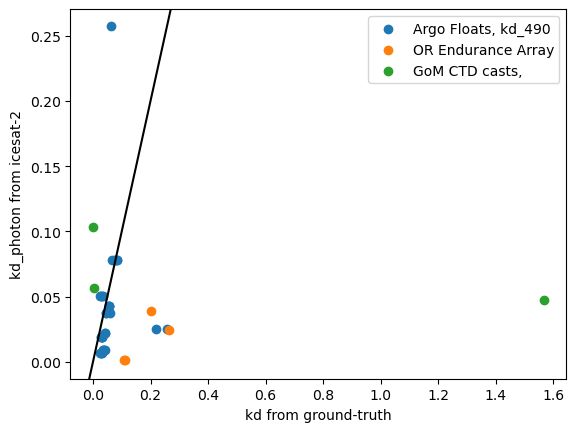

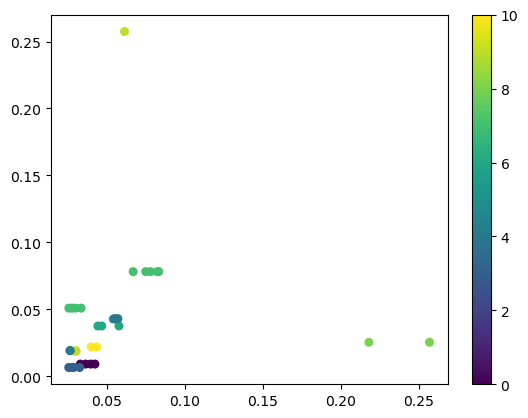

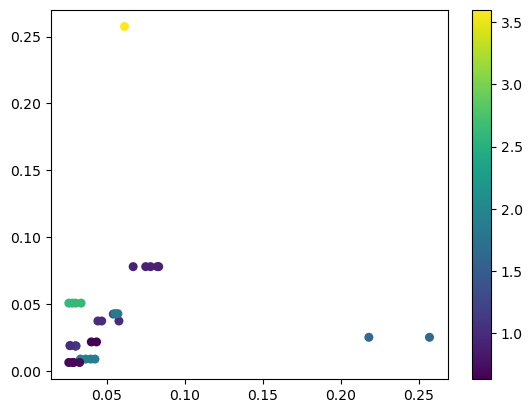

In [27]:
plt.figure()
plt.scatter(argo['kd_490_f'],argo['icesat2_kd'], label = 'Argo Floats, kd_490')
plt.scatter(ooi['kd'],ooi['icesat2_kd'], label = 'OR Endurance Array')
plt.scatter(ws['kd'],ws['icesat2_kd'], label = 'GoM CTD casts, ')
# plt.xlim([-0.01,0.25])
# plt.ylim([-0.01,0.25])
plt.axline((0, 0), slope=1,c='k')
plt.legend()
plt.xlabel('kd from ground-truth')
plt.ylabel('kd_photon from icesat-2')

plt.figure()
p = plt.scatter(argo['kd_490_f'],argo['icesat2_kd'],s = 30, c= argo['time_offset']/3.6e9)
plt.colorbar(p) # color by hour of time offset between ground truth and icesat2

plt.figure()
p = plt.scatter(argo['kd_490_f'],argo['icesat2_kd'],s = 30, c= argo['dist_offset'])
plt.colorbar(p) # color by distance offset (km) between ground truth and icesat2